# 03_SHAP (SHapley Additive exPlanations) - Tree SHAP
### [shap](https://github.com/slundberg/shap): A game theoretic approach to explain the output of any machine learning model.

<img src="slide_image/shap_header.svg" width=720/>

In [5]:
!pip install imblearn shap -q

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from data import Cervical_DataLoader, Bike_DataLoader

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Classification Problem

### Explore the dataset - Risk Factors for Cervical Cancer
#### Features
- Age: 年齡（歲）
- Number of sexual partners: 性伴侶數量
- First sexual intercourse: 首次性行為（歲）
- Num of pregnancies: 懷孕次數
- Smokes: 吸菸與否
- Smokes (years): 煙齡（年）
- Hormonal Contraceptive: 是否服用激素避孕藥
- Hormonal Contraceptives (years): 服用激素避孕藥的時間（年） 
- IUD: 是否有宮內節育器 
- IUD (years): 使用宮內節育器 (IUD) 的年數
- STDs: 是否患有性傳播疾病
- STDs (number): 患有幾個性傳播疾病
- STDs: Number of diagnosis: 性病診斷次數
- STDs: Time since first diagnosis: 第一次性病診斷後到現在的時間
- STDs: Time since last diagnosis: 上次性病診斷到現在的時間

#### Labels
- Biopsy: 健康與否

In [2]:
# Load and preprocess data
data_loader = Cervical_DataLoader()
data_loader.load_dataset()
data_loader.preprocess_data()

# Split the data for evaluation
X_train, X_test, y_train, y_test = data_loader.get_data_split()
print(X_train.shape)
print(X_test.shape)

(686, 17)
(172, 17)


In [3]:
# Oversample the train data
X_train, y_train = data_loader.oversample(X_train, y_train)
print("After oversampling:", X_train.shape)

After oversampling: (1286, 17)


### Classification Moldes

In [4]:
import xgboost
from xgboost import XGBClassifier

#### XGB for Classification

In [5]:
# Fit xgboost for classification model
xgbc = XGBClassifier(random_state=2022)
xgbc.fit(X_train, y_train)
print("Training finished.")
y_pred = xgbc.predict(X_test)
print(f"F1 Score: {round(f1_score(y_test, y_pred, average='macro'), 2)}")
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 2)}")

Training finished.
F1 Score: 0.55
Accuracy: 0.92


#### Classic feature attributions

How the importance is calculated: either “weight”, “gain”, or “cover”
- ”weight”: 在所有樹中，某特徵被用來分裂節點的次數
- ”gain”: 在所有樹中，某特徵在每次分裂節點時帶來的平均增益
- ”cover”: 在所有樹中，某特徵在每次分裂節點時處理 (覆蓋) 的樣本的平均數量 

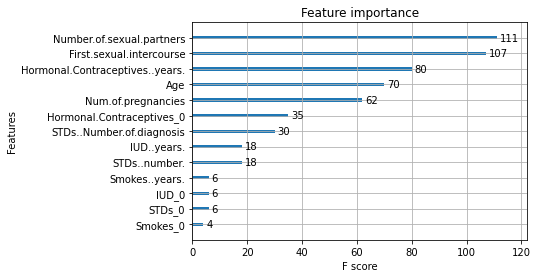

In [6]:
xgboost.plot_importance(xgbc, importance_type='weight')

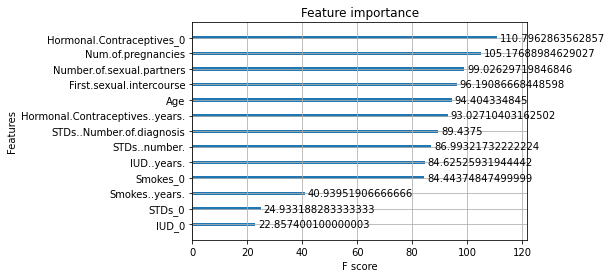

In [7]:
xgboost.plot_importance(xgbc, importance_type='cover')

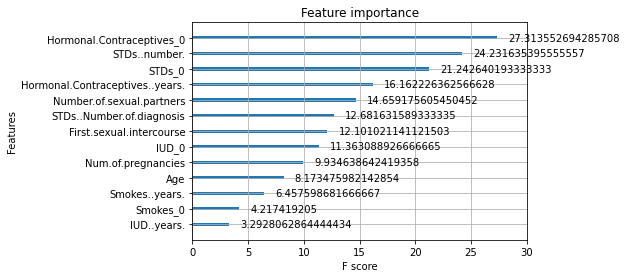

In [8]:
xgboost.plot_importance(xgbc, importance_type='gain')

### Tree SHAP to explain tree model

In [9]:
import shap
shap.initjs()

In [10]:
explainer = shap.TreeExplainer(xgbc)
shap_values = explainer(X=X_test)

In [11]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values.shape}')

length of SHAP values: 172
Shape of each element: (172, 17)


#### Global interpretability
- 點的顏色: Feature value 的大小，越紅越大、越藍越小
- X 軸: 該點對於 shap value 的影響，也就是對預測值的影響。
- Y 軸: 各個 features

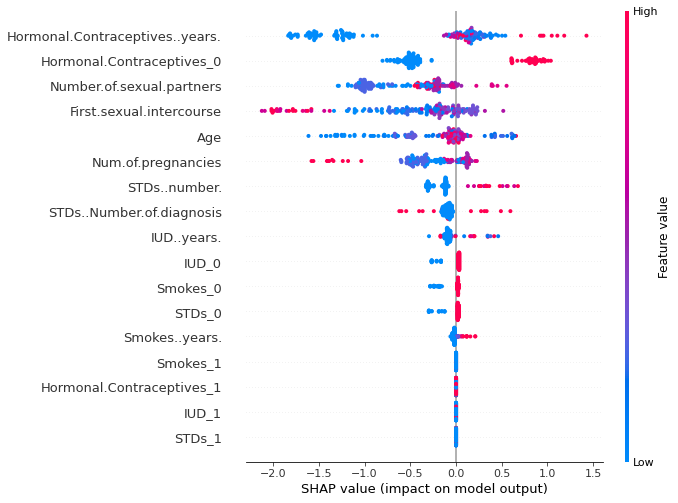

In [15]:
shap.summary_plot(shap_values, X_test)

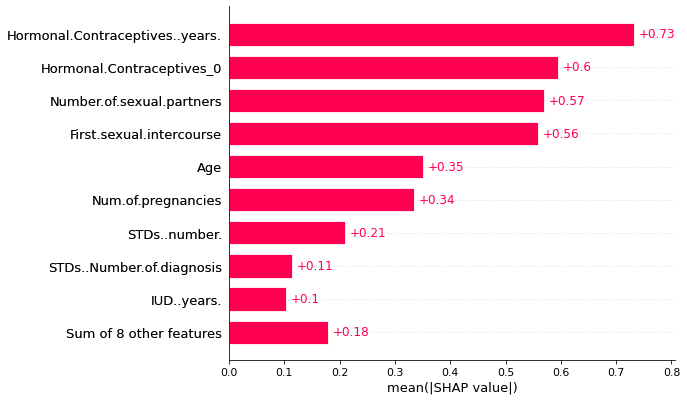

In [16]:
shap.plots.bar(shap_values)

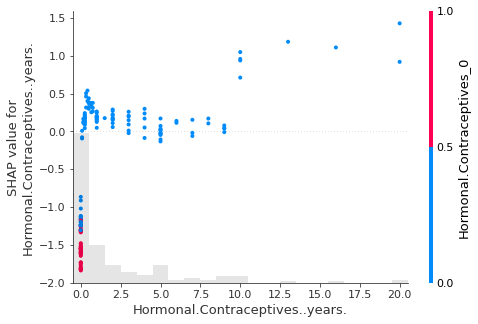

In [20]:
shap.plots.scatter(shap_values[:, "Hormonal.Contraceptives..years."], color=shap_values[:, "Hormonal.Contraceptives_0"])

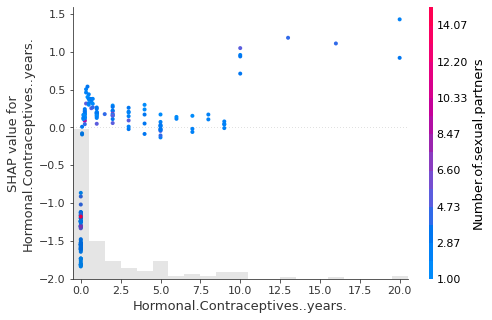

In [21]:
shap.plots.scatter(shap_values[:, "Hormonal.Contraceptives..years."], color=shap_values[:, "Number.of.sexual.partners"])

#### Local interpretability

Explain a single prediction from the test set

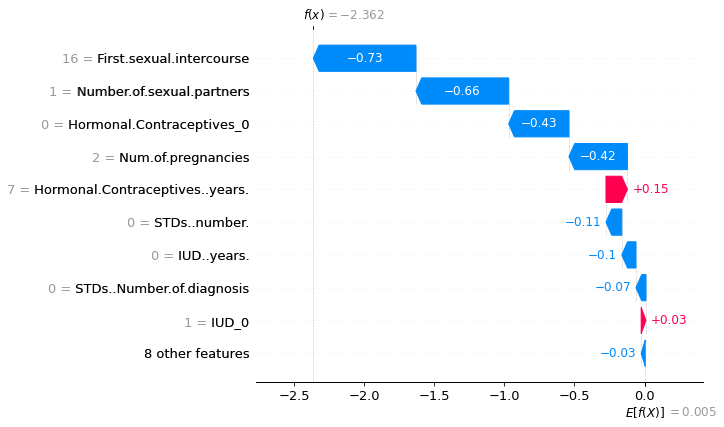

In [12]:
# waterfall
shap.plots.waterfall(shap_values[0])

In [13]:
# plot the SHAP values for output of the first instance
print(f'Prediction for 1st sample in X_test: {xgbc.predict_proba(X_test.iloc[[0], :])[0]}')
shap.force_plot(explainer.expected_value, shap_values.values[0], X_test.iloc[0])

Prediction for 1st sample in X_test: [0.9139003  0.08609968]


Explain all the predictions in the test set

In [14]:
shap.force_plot(explainer.expected_value, shap_values.values, X_test)

## Regression Problem

### Explore the dataset - Bike Rentals
#### Features
- season: 季節，包含春、夏、秋、冬
- yr: 年份，2011 年或 2012 年
- mnth: 月份，1~12 月
- holiday: 當天是否為假期
- weekday: 星期幾
- workingday: 當天是否為工作日
- weathersit: 那天的天氣情況是下面幾種狀況的其中一個
    - GOOD: 晴朗
    - MISTY: 有霧、有雲
    - RAIN/SNOW/STORM: 下雨、下雪、暴風
- temp: 溫度（攝氏度）
- hum: 相對濕度百分比（0~100%）
- windspeed: 風速(km/h)
- days_since_2011: 自 2011 年 1 月 1 日（數據集中的第一天）起的天數。引入此特性是為了考慮隨時間變化的趨勢。

#### Labels
- cnt: 自行車租賃的數量，也就是此回歸任務的預測目標

In [23]:
# Load and preprocess data
data_loader = Bike_DataLoader()
data_loader.load_dataset()
data_loader.preprocess_data()
data_loader.data

# Split the data for evaluation
X_train, X_test, y_train, y_test = data_loader.get_data_split()
print(X_train.shape)
print(X_test.shape)

(584, 36)
(147, 36)


### Regression Moldes

In [24]:
from xgboost import XGBRegressor

#### XGB for Regression

In [26]:
# Fit xgb for regression model
xgbr = XGBRegressor(random_state=2022)
xgbr.fit(X_train, y_train)
print("Training finished.")
y_pred = xgbr.predict(X_test)
print(f"Root Mean Squared Error: {round(mean_squared_error(y_test, y_pred)**(1/2), 2)}")
print(f"R2: {round(r2_score(y_test, y_pred), 2)}")

[17:49:02] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training finished.
Root Mean Squared Error: 613.53
R2: 0.88


#### Classic feature attributions

How the importance is calculated: either “weight”, “gain”, or “cover”
- ”weight”: 在所有樹中，某特徵被用來分裂節點的次數
- ”gain”: 在所有樹中，某特徵在每次分裂節點時帶來的平均增益
- ”cover”: 在所有樹中，某特徵在每次分裂節點時處理 (覆蓋) 的樣本的平均數量 

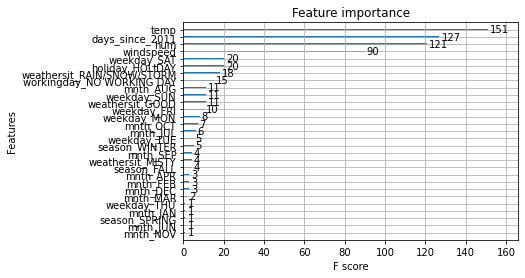

In [27]:
xgboost.plot_importance(xgbr, importance_type='weight')

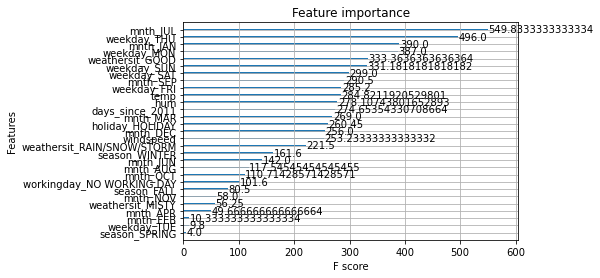

In [28]:
xgboost.plot_importance(xgbr, importance_type='cover')

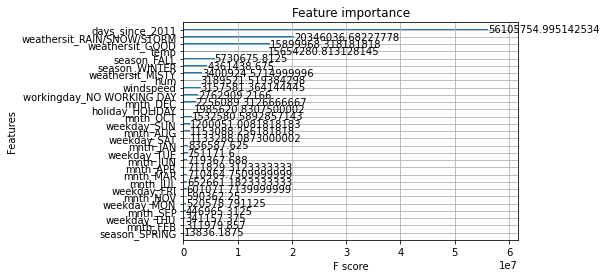

In [29]:
xgboost.plot_importance(xgbr, importance_type='gain')

### Tree SHAP to explain tree model

In [30]:
import shap
shap.initjs()

In [31]:
explainer = shap.TreeExplainer(xgbr)
shap_values = explainer(X=X_test)

In [32]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values.shape}')

length of SHAP values: 147
Shape of each element: (147, 36)


#### Global interpretability
- 點的顏色: Feature value 的大小，越紅越大、越藍越小
- X 軸: 該點對於 shap value 的影響，也就是對預測值的影響。
- Y 軸: 各個 features

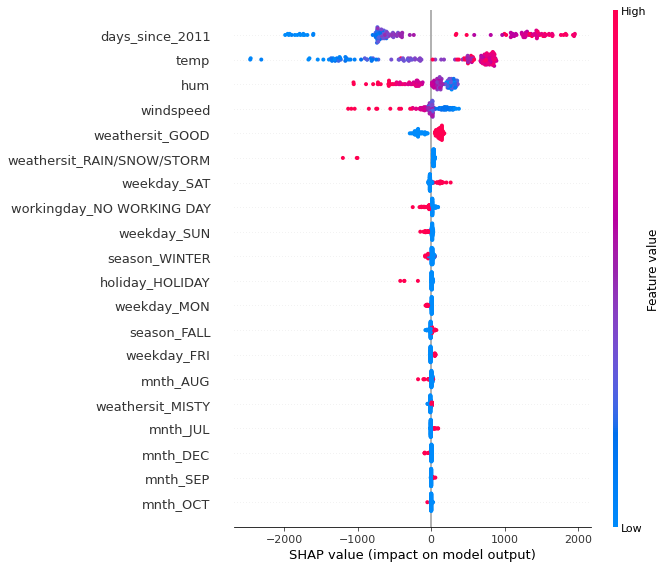

In [38]:
shap.summary_plot(shap_values, X_test)

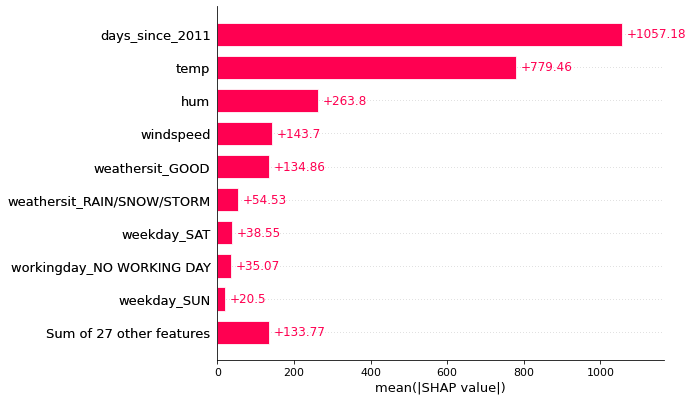

In [39]:
shap.plots.bar(shap_values)

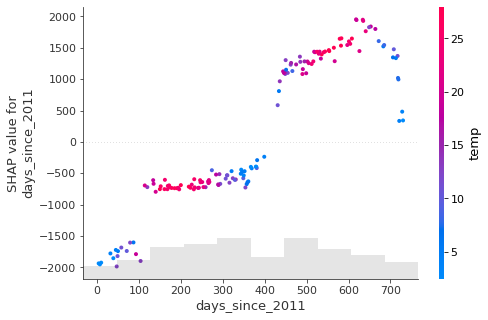

In [41]:
shap.plots.scatter(shap_values[:, "days_since_2011"], color=shap_values[:, "temp"])

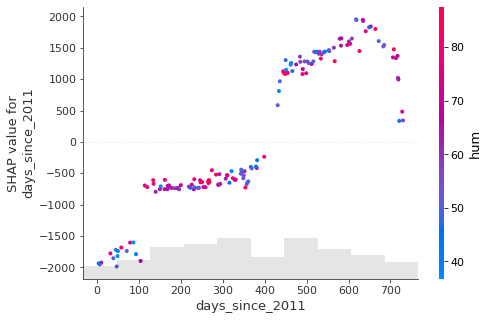

In [42]:
shap.plots.scatter(shap_values[:, "days_since_2011"], color=shap_values[:, "hum"])

#### Local interpretability

Explain a single prediction from the test set

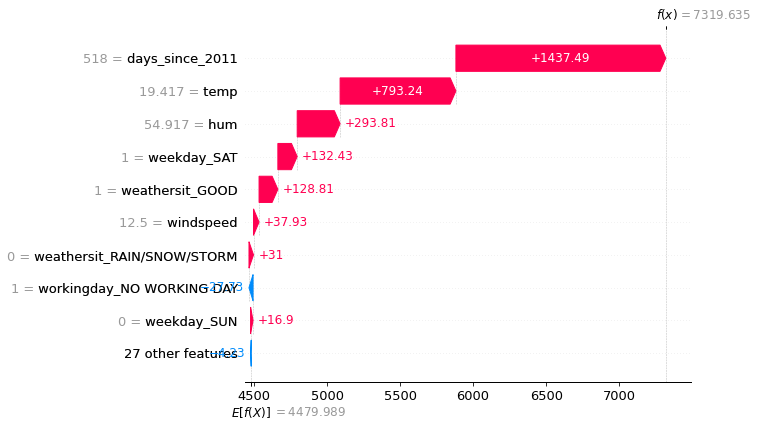

In [33]:
# waterfall
shap.plots.waterfall(shap_values[0])

In [36]:
# plot the SHAP values for output of the first instance
print(f'Prediction for 1st sample in X_test: {xgbr.predict(X_test.iloc[[0], :])[0]}')
shap.force_plot(explainer.expected_value, shap_values.values[0], X_test.iloc[0])

Prediction for 1st sample in X_test: 7319.6357421875


Explain all the predictions in the test set

In [37]:
shap.force_plot(explainer.expected_value, shap_values.values, X_test)